# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Цель:** Построить модель для определения региона, где добыча принесёт наибольшую прибыль.
     
   Работа пройдёт в несколько этапов:
 1. Загрузка и подготовка данных.
 2. Обучение и проверка модели.
 3. Подготовка к расчёту прибыли.
 4. Расчёт прибыли и рисков.

**Описание данных:**

+ id — уникальный идентификатор скважины;
+ f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
+ product — объём запасов в скважине (тыс. баррелей).

Условия задачи:
+ Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
+ При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
+ Бюджет на разработку скважин в регионе — 10 млрд рублей.
+ При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
+ После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [1]:
# подключаем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from scipy import stats as st

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# округляем значения до четырёх знаков после запятой
pd.options.display.float_format = '{:.4f}'.format

REGION_OIL_WELL = 500
BEST_OIL_WELL = 200
BUDGET = 10e9
ONE_INCOME = 450e3
LOSS_PROBABILITY = 2.5

## Загрузка и подготовка данных

Загрузим наши три датасета.

In [2]:
if os.path.exists('8. geo_data_0.csv'):
    df_0 = pd.read_csv('8. geo_data_0.csv')
elif os.path.exists('/datasets/geo_data_0.csv'):
    df_0 = pd.read_csv('/datasets/geo_data_0.csv')
else:
    print('Nothing works.')
df_0.head()

,id,f0,f1,f2,product
0,txEyH,0.7057,-0.4978,1.2212,105.2801
1,2acmU,1.3347,-0.3402,4.3651,73.0378
2,409Wp,1.0227,0.1520,1.4199,85.2656
3,iJLyR,-0.0322,0.1390,2.9786,168.6208
4,Xdl7t,1.9884,0.1554,4.7518,154.0366


In [3]:
if os.path.exists('8. geo_data_1.csv'):
    df_1 = pd.read_csv('8. geo_data_1.csv')
elif os.path.exists('/datasets/geo_data_1.csv'):
    df_1 = pd.read_csv('/datasets/geo_data_1.csv')
else:
    print('Nothing works.')
df_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.0013,-8.2760,-0.0059,3.1791
1,62mP7,14.2721,-3.4751,0.9992,26.9533
2,vyE1P,6.2632,-5.9484,5.0012,134.7663
3,KcrkZ,-13.0812,-11.5061,4.9994,137.9454
4,AHL4O,12.7022,-8.1474,5.0044,134.7663


In [4]:
if os.path.exists('8. geo_data_2.csv'):
    df_2 = pd.read_csv('8. geo_data_2.csv')
elif os.path.exists('/datasets/geo_data_2.csv'):
    df_2 = pd.read_csv('/datasets/geo_data_2.csv')
else:
    print('Nothing works.')
df_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.1470,0.9633,-0.8290,27.7587
1,WJtFt,0.2628,0.2698,-2.5302,56.0697
2,ovLUW,0.1946,0.2890,-5.5864,62.8719
3,q6cA6,2.2361,-0.5538,0.9300,114.5728
4,WPMUX,-0.5160,1.7163,5.8990,149.6007


In [5]:
# напишем функцию для описания и просмотра данных
def description(df):
    df.info()
    display(df.describe())
    print('Количество дубликатов', df.duplicated().sum())
    print('Количество дубликатов по "id"', df['id'].duplicated().sum())
    plt.figure(figsize = (8, 6))
    sns.heatmap(df.corr(), annot=True, annot_kws={'size':16})
    plt.figure(figsize = (8, 6))
    sns.histplot(df['product'])

### Первый регион

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.0000,100000.0000,100000.0000,100000.0000
mean,0.5004,0.2501,2.5026,92.5000
std,0.8718,0.5044,3.2482,44.2887
min,-1.4086,-0.8482,-12.0883,0.0000
25%,-0.0726,-0.2009,0.2877,56.4975
50%,0.5024,0.2503,2.5160,91.8500
75%,1.0736,0.7006,4.7151,128.5641
max,2.3623,1.3438,16.0038,185.3643


Количество дубликатов 0
Количество дубликатов по "id" 10


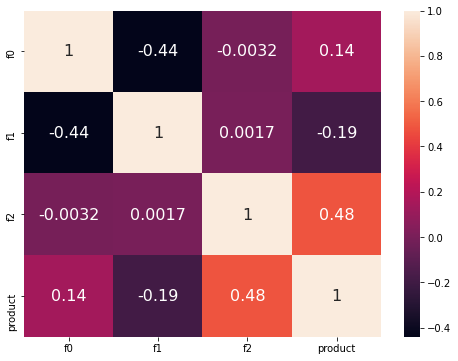

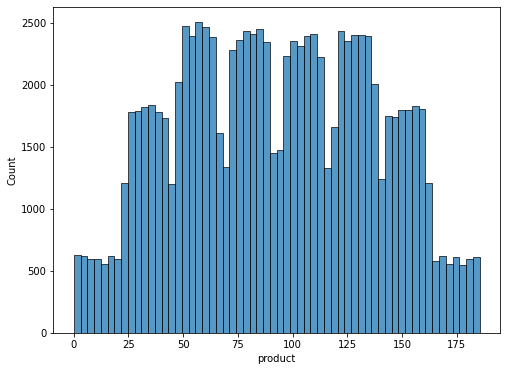

In [6]:
description(df_0)

In [7]:
df_0.groupby('product')['product'].count()

product
0.0000      1
0.0040      1
0.0061      1
0.0094      1
0.0218      1
           ..
185.3520    1
185.3550    1
185.3556    1
185.3627    1
185.3643    1
Name: product, Length: 100000, dtype: int64

### Второй регион

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.0000,100000.0000,100000.0000,100000.0000
mean,1.1413,-4.7966,2.4945,68.8250
std,8.9659,5.1199,1.7036,45.9444
min,-31.6096,-26.3586,-0.0181,0.0000
25%,-6.2986,-8.2680,1.0000,26.9533
50%,1.1531,-4.8132,2.0115,57.0856
75%,8.6210,-1.3328,3.9999,107.8130
max,29.4218,18.7341,5.0197,137.9454


Количество дубликатов 0
Количество дубликатов по "id" 4


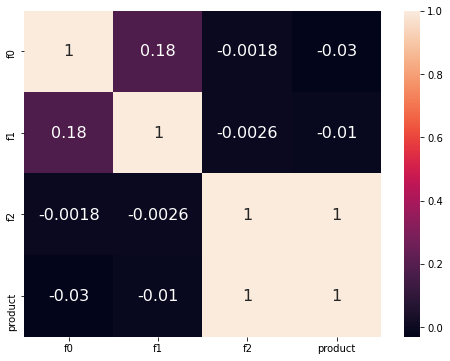

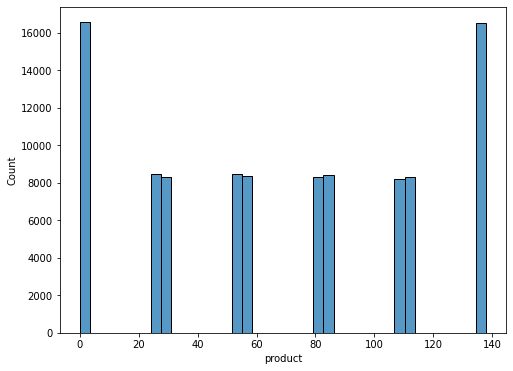

In [8]:
description(df_1)

In [9]:
df_1.groupby('product')['product'].count()

product
0.0000      8235
3.1791      8337
26.9533     8468
30.1324     8306
53.9065     8472
57.0856     8390
80.8598     8320
84.0389     8431
107.8130    8201
110.9921    8303
134.7663    8304
137.9454    8233
Name: product, dtype: int64

### Третий регион

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,f0,f1,f2,product
count,100000.0000,100000.0000,100000.0000,100000.0000
mean,0.0020,-0.0021,2.4951,95.0000
std,1.7320,1.7304,3.4734,44.7499
min,-8.7600,-7.0840,-11.9703,0.0000
25%,-1.1623,-1.1748,0.1304,59.4504
50%,0.0094,-0.0095,2.4842,94.9256
75%,1.1585,1.1637,4.8588,130.5950
max,7.2383,7.8448,16.7394,190.0298


Количество дубликатов 0
Количество дубликатов по "id" 4


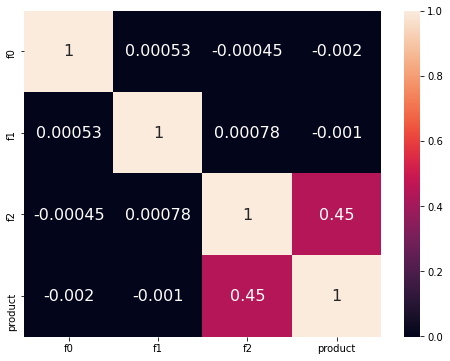

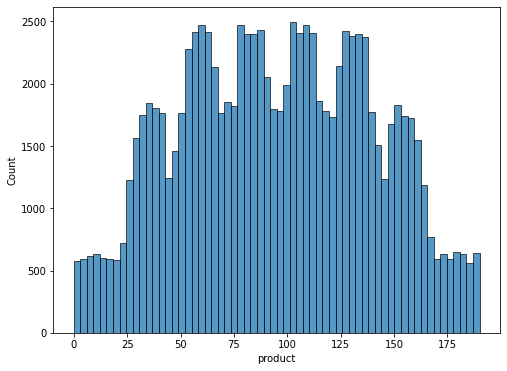

In [10]:
description(df_2)

<font color="blue" size="5"><u><b>Выводы по пункту 1:<b/><u/></font>   
    
**В данных по трём регионам:**  
+ пропуски отсутствуют   
+ дубликаты отсутствуют
+ типы данных соответствуют   
+ присутствует небольшая корреляция между целевым признаком и "f2", в случае второго региона корреляция 100%
+ значения целевого признака в 1 и 3 регионах примерно одинаковые(мин, макс, среднее), во 2-ом несколько ниже
    
В 1 и 3 регионах значения таргета распределены нормально. Во 2-ом вообще не очень понятно - 12 значений с одинаковым объёмом запасов в 8 с лишним тысячах скважин, 8235 скважин с нулевым объёмом)))

## Обучение и проверка модели

**Напишем функции для разбивки данных на обучающую и валидационную выборки в соотношении 75:25
 и для вывода метрик. Масштабирование признаков мы делать не будем, так как в них нет разброса значений.**

In [11]:
def split_df(df):
    X = df.drop(['product', 'id'], axis=1)
    y = df['product']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=123)
    return X_train, X_val, y_train, y_val.reset_index(drop=True)

In [12]:
def metrics(y_val, pred_valid):
    mse = mean_squared_error(y_val, pred_valid)
    print(f'MSE = {mse:.5f}')
    print(f'RMSE = {mse ** 0.5:.5f}')
    print(f'Коэффициент детерминации(R2) = {r2_score(y_val, pred_valid):.5f}')
    print(f'Средний запас предсказанного сырья = {pred_valid.mean():.5f}')
    print(f'Средний запас реального сырья = {y_val.mean():.5f}')

### Первый регион

In [13]:
X_train_1, X_val_1, y_train_1, y_val_1 = split_df(df_0)
X_train_1.shape, y_train_1.shape

((75000, 3), (75000,))

In [14]:
model_1 = LinearRegression()
model_1.fit(X_train_1, y_train_1)
pred_valid_1 = pd.Series(model_1.predict(X_val_1)) 

In [15]:
metrics(y_val_1, pred_valid_1)

MSE = 1417.36158
RMSE = 37.64786
Коэффициент детерминации(R2) = 0.28130
Средний запас предсказанного сырья = 92.54936
Средний запас реального сырья = 92.85062


### Второй регион

In [16]:
X_train_2, X_val_2, y_train_2, y_val_2 = split_df(df_1)
X_train_2.shape, y_train_2.shape

((75000, 3), (75000,))

In [17]:
model_2 = LinearRegression()
model_2.fit(X_train_2, y_train_2)
pred_valid_2 = pd.Series(model_2.predict(X_val_2))

In [18]:
metrics(y_val_2, pred_valid_2)

MSE = 0.80177
RMSE = 0.89541
Коэффициент детерминации(R2) = 0.99962
Средний запас предсказанного сырья = 69.28002
Средний запас реального сырья = 69.27371


### Третий регион

In [19]:
X_train_3, X_val_3, y_train_3, y_val_3 = split_df(df_2)
X_train_3.shape, y_train_3.shape

((75000, 3), (75000,))

In [20]:
model_3 = LinearRegression()
model_3.fit(X_train_3, y_train_3)
pred_valid_3 = pd.Series(model_3.predict(X_val_3)) 

In [21]:
metrics(y_val_3, pred_valid_3)

MSE = 1610.25880
RMSE = 40.12803
Коэффициент детерминации(R2) = 0.19314
Средний запас предсказанного сырья = 95.09860
Средний запас реального сырья = 94.87349


<font color="blue" size="5"><u><b>Выводы по пункту 2:<b/><u/></font>   
    
**Мы обучили модели для каждого региона, сравнили предсказания и правильные ответы на валидационной выборке. По результатам можно сказать, что лучше всего модель делает предсказания для 2-ого региона. R2 почти 1, модель предсказывает все ответы почти идеально. RMSE = 0.89541. Это и понятно, учитывя, что в датасете для второго региона всего 12 значений))). На втором месте 1-ый регион с RMSE = 37.64786. И 3-ий на третьем c RMSE = 40.12803.**

## Подготовка к расчёту прибыли

In [22]:
# посчитаем минимальный доход с одной скважины (из 200 лучших), чтобы уйти в ноль
income_best_oil_well = BUDGET / BEST_OIL_WELL
income_best_oil_well

50000000.0

In [23]:
# достаточный объём сырья для безубыточной разработки новой скважины (тыс. баррелей)
count_best_oil_well = income_best_oil_well / ONE_INCOME
count_best_oil_well

111.11111111111111

Сравним необходимый объём со средним по регионам.

In [24]:
print('Средний объём по региону 1 = {:.4f}'.format(df_0['product'].mean()))
print('Средний объём по региону 2 = {:.4f}'.format(df_1['product'].mean()))
print('Средний объём по региону 3 = {:.4f}'.format(df_2['product'].mean()))

Средний объём по региону 1 = 92.5000
Средний объём по региону 2 = 68.8250
Средний объём по региону 3 = 95.0000


<font color="blue" size="5"><u><b>Выводы по пункту 3:<b/><u/></font>   
    
**Средние показатели по регионам явно не дотягивают до необходимого объёма. Необходимо рассмотреть скважины с наибольшими запасами.**

## Расчёт прибыли и рисков 

**Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели. Выберем скважины с максимальными значениями предсказаний. Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям. Рассчитаем прибыль для полученного объёма сырья для каждого региона.**

In [25]:
def revenue(y_val, pred_valid):
    probs_sorted = pred_valid.sort_values(ascending=False)
    selected = y_val[probs_sorted.index][:BEST_OIL_WELL] 
    return ONE_INCOME * selected.sum() - BUDGET

In [26]:
print('Прибыль для полученного объёма сырья 1-ого региона =', revenue(y_val_1, pred_valid_1))
print('Прибыль для полученного объёма сырья 2-ого региона =', revenue(y_val_2, pred_valid_2))
print('Прибыль для полученного объёма сырья 3-ого региона =', revenue(y_val_3, pred_valid_3))

Прибыль для полученного объёма сырья 1-ого региона = 3534670917.261383
Прибыль для полученного объёма сырья 2-ого региона = 2415086696.681511
Прибыль для полученного объёма сырья 3-ого региона = 2370343863.0213737


**Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.**

In [27]:
state = np.random.RandomState(123)

In [28]:
def boost_1000(y_val, pred_valid):
    values = []
    for i in range(1000):
        y_subsample = y_val.sample(REGION_OIL_WELL, replace=True, random_state=state)
        probs_subsample = pred_valid[y_subsample.index] 
        values.append(revenue(y_subsample, probs_subsample))

    value = pd.Series(values)
    lower = value.quantile(.025)
    upper = value.quantile(.975)
    conf_interval = st.t.interval(.95, df=len(value) - 1, loc=value.mean(), scale=value.sem())
    risk_loss = len(value[value < 0]) / len(value)

    print(f'Средняя выручка: {value.mean():.3f}')
    print('95%-ый доверительный интервал для истинного среднего:', conf_interval)
    print(f'95%-ый доверительный интервал для прогнозируемого среднего: ({lower:.3f}, {upper:.3f})')
    print(f'Риск убытков: {risk_loss:.1%}')
    if risk_loss*100 < LOSS_PROBABILITY:
        print('Вероятность убытков меньше 2.5%.\nРегион подходит для разработки. ')
    else:
        print('Регион не подходит для разработки. ')

**Применим функцию для трёх регионов.**

### Первый регион

In [29]:
boost_1000(y_val_1, pred_valid_1)

Средняя выручка: 504778653.647
95%-ый доверительный интервал для истинного среднего: (487662578.2855772, 521894729.00911546)
95%-ый доверительный интервал для прогнозируемого среднего: (-51833206.451, 1029933076.495)
Риск убытков: 4.0%
Регион не подходит для разработки. 


### Второй регион

In [30]:
boost_1000(y_val_2, pred_valid_2)

Средняя выручка: 525920709.346
95%-ый доверительный интервал для истинного среднего: (512427486.2738292, 539413932.4185855)
95%-ый доверительный интервал для прогнозируемого среднего: (100008906.849, 945010745.142)
Риск убытков: 0.9%
Вероятность убытков меньше 2.5%.
Регион подходит для разработки. 


### Третий регион

In [31]:
boost_1000(y_val_3, pred_valid_3)

Средняя выручка: 386984654.506
95%-ый доверительный интервал для истинного среднего: (369530940.2003521, 404438368.8116574)
95%-ый доверительный интервал для прогнозируемого среднего: (-174251108.634, 933803042.810)
Риск убытков: 7.7%
Регион не подходит для разработки. 


<font color="blue" size="5"><u><b>Выводы по пункту 3:<b/><u/></font>  
    
**По всем расчетам Лучший для разработки является второй регион.**

## Общий вывод:

**В данных по трём регионам:**  
+ пропуски отсутствуют   
+ дубликаты отсутствуют
+ типы данных соответствуют   
+ присутствует небольшая корреляция между целевым признаком и "f2", в случае второго региона корреляция 100%
+ значения целевого признака в 1 и 3 регионах примерно одинаковые(мин, макс, среднее), во 2-ом несколько ниже
    
В 1 и 3 регионах значения таргета распределены нормально. Во 2-ом - 12 значений с одинаковым объёмом запасов в 8 с лишним тысячах скважин.  
Мы обучили модели для каждого региона, сравнили предсказания и правильные ответы на валидационной выборке. По результатам можно сказать, что лучше всего модель делает предсказания для 2-ого региона. R2 почти 1, модель предсказывает все ответы почти идеально. RMSE = 0.89541. Это и понятно, учитывя, что в датасете для второго региона всего 12 значений))). На втором месте 1-ый регион с RMSE = 37.64786. И 3-ий на третьем c RMSE = 40.12803.                
Средние показатели по регионам явно не дотягивают до необходимого объёма.       
Применли технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли. Нашли среднюю прибыль, 95%-й доверительный интервал и риск убытков.                   
**По всем расчетам лучший для разработки является второй регион. Хотя, для меня он и кажется каким-то фейковым (Я бы выбрал первый, но по условию он не подходит).**